In [1]:
%matplotlib inline
import os
import tqdm
import os.path as osp
import pandas as pd
import numpy as np
import itertools
import glob
import json 
import plotnine as pn
import matplotlib.pyplot as plt
import collections
from tcre.env import *
from tcre.supervision import get_candidate_classes, SPLIT_DEV, SPLIT_VAL, SPLIT_TEST, SPLIT_TRAIN, SPLIT_MAP
from tcre.exec.v1 import optim
from tcre.modeling import features
from snorkel.learning.utils import LabelBalancer
from snorkel import SnorkelSession
from snorkel.models import Candidate
import logging
session = SnorkelSession()
%run ../src/tcre/logging.py
classes = get_candidate_classes()

/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [18]:
#output_dir = osp.join(RESULTS_DATA_DIR, 'modeling-rnn-all', 'run1') # W supervised LFs
#output_dir = osp.join(RESULTS_DATA_DIR, 'modeling-rnn-all', 'run2')  # W/o supervised LFs
output_dir = osp.join(RESULTS_DATA_DIR, 'modeling-rnn-all', 'run3')  # W/ more annotations and LFs
output_dir

'/lab/data/results/modeling-rnn-all/run3'

In [3]:
tasks = [classes[c].field for c in classes]
tasks

['inducing_cytokine', 'secreted_cytokine', 'inducing_transcription_factor']

### Initialize Optimizers

In [4]:
from skopt.space import Categorical
from skopt.space import Space

# inducing cytokine: {'marker_list': 'doub_01', 'use_secondary': True, 'use_swaps': True, 'use_positions': True, 'wrd_embedding_type': 'w2v_trained', 
# 'model_size': 'XXXXL', 'weight_decay': 0.0, 'learning_rate': 0.01, 'dropout': 0.75, 'cell_type': 'LSTM', 'bidirectional': False, 
# 'score': 0.521739130434782, 'task': 'inducing_cytokine', 'iteration': 0}
space = Space([
    Categorical(['doub_01'], name='marker_list'),
    Categorical([True, False], name='use_secondary'),
    Categorical([True], name='use_swaps'),
    Categorical([True], name='use_positions'),
    Categorical(['w2v_frozen', 'w2v_trained'], name='wrd_embedding_type'),
    Categorical(['XL', 'XXL', 'XXXL', 'XXXXL'], name='model_size'),
    Categorical([0.0, .0001, .001, .005], name='weight_decay'),
    Categorical([.005, .01, .05], name='learning_rate'),
    Categorical([0.0, 0.25, 0.5, 0.75], name='dropout'),
    Categorical(['LSTM'], name='cell_type'),
    Categorical([False], name='bidirectional')
])

In [5]:
n_space = np.prod([len(dim.categories) for dim in space])
print('Number of combinations in parameter space:', n_space)

Number of combinations in parameter space: 768


In [6]:
from skopt import forest_minimize, dummy_minimize
client_args = dict(cli=dict(batch_size=512), train=dict(log_iter_interval=150, log_epoch_interval=5))
optimizers = {
    task: optim.TaskParameterOptimizer(task, space, output_dir, minimizer=dummy_minimize, client_args=client_args) 
    for task in tasks
}

### Create Splits for Tasks

In [7]:
cands = session.query(Candidate).filter(Candidate.split.in_([SPLIT_VAL, SPLIT_TEST, SPLIT_TRAIN])).all()
len(cands)

31443

In [8]:
# DB splits -> modeling splits 
TARGET_MAP = {'train': 'train', 'val': 'val', 'test': 'test'}
df_cand = features.get_candidate_labels(session, splits=[SPLIT_VAL, SPLIT_TEST, SPLIT_TRAIN]).rename(columns={'type': 'task'})
df_cand['split'] = df_cand['split'].map(SPLIT_MAP).map(TARGET_MAP)
df_cand.groupby(['task', 'split']).size()

task                           split
inducing_cytokine              test       271
                               train    10000
                               val        203
inducing_transcription_factor  test       281
                               train    10000
                               val        209
secreted_cytokine              test       274
                               train    10000
                               val        205
dtype: int64

In [9]:
df_cand[df_cand['split'] == 'train']['label'].value_counts().sort_values().tail(5)

0.035663    218
0.000001    221
0.794359    257
0.086803    290
0.979250    328
Name: label, dtype: int64

In [10]:
df_cand[df_cand['split'] != 'train']['label'].value_counts()

0.0    1226
1.0     217
Name: label, dtype: int64

In [11]:
max_train_samples = 3000
for task, g in df_cand.groupby('task'):
    _rs = lambda: np.random.RandomState(TCRE_SEED)
    
    def get_ids(df):
        split = df['split'].iloc[0]
        if split == 'predict':
            return df['id'].unique()
        df = df[(df['label'] - .5).abs() > 1e-6]
        idx = LabelBalancer(df['label'].values).get_train_idxs(rand_state=_rs(), rebalance=.5)
        if split == 'train' and len(df) > max_train_samples:
            idx = _rs().choice(idx, size=max_train_samples, replace=False)
        df = df.iloc[idx]
        print(f'Label distribution for split {split}:', (df['label'] > .5).value_counts().to_dict())
        return df['id'].unique()
    splits = g.groupby('split').apply(get_ids)
    print(f'Splits for task "{task}":')
    print(splits.apply(len))
    splits_file = optimizers[task].write_splits(splits)
    print(f'Splits written to {splits_file}')

Label distribution for split test: {True: 25, False: 25}
Label distribution for split test: {True: 25, False: 25}
Label distribution for split train: {True: 1536, False: 1464}
Label distribution for split val: {True: 14, False: 14}
Splits for task "inducing_cytokine":
split
test       50
train    3000
val        28
dtype: int64
Splits written to /lab/data/results/training-classifier/run3/inducing_cytokine/splits/splits.json
Label distribution for split test: {True: 57, False: 57}
Label distribution for split test: {True: 57, False: 57}
Label distribution for split train: {False: 1506, True: 1494}
Label distribution for split val: {True: 35, False: 35}
Splits for task "inducing_transcription_factor":
split
test      114
train    3000
val        70
dtype: int64
Splits written to /lab/data/results/training-classifier/run3/inducing_transcription_factor/splits/splits.json
Label distribution for split test: {True: 50, False: 50}
Label distribution for split test: {True: 50, False: 50}
Label 

### Run Search

In [12]:
# Show an example command to be run 
print(optimizers[tasks[0]].get_cmd(space.rvs()[0]))

python /lab/repos/t-cell-relation-extraction/src/tcre/exec/v1/cli.py --relation-class=inducing_cytokine --device="cuda:1" --output-dir=/lab/data/results/training-classifier/run3/inducing_cytokine/data --batch-size=512 train --splits-file=/lab/data/results/training-classifier/run3/inducing_cytokine/splits/splits.json --use-checkpoints=False --save-keys="history" --log-iter-interval=150 --log-epoch-interval=5 --marker-list=doub_01 --use-secondary=True --use-swaps=True --use-positions=True --wrd-embedding-type=w2v_frozen --model-size=XXXL --weight-decay=0.005 --learning-rate=0.01 --dropout=0.5 --cell-type=LSTM --bidirectional=False > /lab/data/results/training-classifier/run3/inducing_cytokine/log/log.txt 2>&1


In [13]:
# 10k train --> 200s / it 
# Downsampling --> 63s / it 
# For 3 tasks at about about 200s per iteration, show common time estimations:
time_per_iter_sec = 63
n_iter = np.array([10, 100, 250, 500, 1000])
for n in n_iter:
    time = n * time_per_iter_sec * len(tasks) / 3600
    print(f'Iterations = {n} --> Time = {time} (hrs)')

Iterations = 10 --> Time = 0.525 (hrs)
Iterations = 100 --> Time = 5.25 (hrs)
Iterations = 250 --> Time = 13.125 (hrs)
Iterations = 500 --> Time = 26.25 (hrs)
Iterations = 1000 --> Time = 52.5 (hrs)


In [14]:
results = {}

for task in tasks:
    optimizer = optimizers[task]
    logging.info(f'Running optimization for task {task}')
    res, scores, callbacks = optimizer.run(n_iterations=32, progress_interval=1, checkpoint_interval=1)
    
    # Save scores for non-objective (i.e. validation) after converting to long form
    scores = pd.DataFrame(scores)
    scores.columns = pd.MultiIndex.from_tuples([c for c in scores])
    scores = scores.rename_axis('iteration', axis=0).rename_axis(('metric', 'type'), axis=1)
    scores = scores.stack().stack().rename('value').reset_index()
    scores_file = osp.join(optimizer.output_dir, 'scores.feather')
    scores.to_feather(scores_file)
    logging.info(f'Saved scores to {scores_file}')
    
    # Checkpoint final result since it is not saved at every step
    callbacks['saver'].i = -1
    callbacks['saver'](res)
    logging.info(f'Saved final result')
    
    results[task] = res, scores, callbacks

2019-08-05 16:49:35,057:INFO:root: Running optimization for task inducing_cytokine
2019-08-05 16:49:35,059:INFO:tcre.exec.v1.optim: Beginning parameter search with max iterations 32
2019-08-05 16:50:39,472:INFO:tcre.exec.v1.optim: Saving checkpoint to /lab/data/results/training-classifier/run3/inducing_cytokine/checkpoints/checkpoint.pkl
2019-08-05 16:50:39,492:INFO:tcre.exec.v1.optim: Completed iteration 1 of 32 (score = -0.625)
2019-08-05 16:52:04,681:INFO:tcre.exec.v1.optim: Saving checkpoint to /lab/data/results/training-classifier/run3/inducing_cytokine/checkpoints/checkpoint.pkl
2019-08-05 16:52:04,702:INFO:tcre.exec.v1.optim: Completed iteration 2 of 32 (score = -0.75)
2019-08-05 16:53:10,182:INFO:tcre.exec.v1.optim: Saving checkpoint to /lab/data/results/training-classifier/run3/inducing_cytokine/checkpoints/checkpoint.pkl
2019-08-05 16:53:10,205:INFO:tcre.exec.v1.optim: Completed iteration 3 of 32 (score = -0.6666666666666661)
2019-08-05 16:54:03,173:INFO:tcre.exec.v1.optim: S

In [15]:
print(tasks[0])
res, scores, callbacks = results[tasks[0]]

inducing_cytokine


In [16]:
times = callbacks['timer'].iter_time
pd.Series(times).describe()

count    32.000000
mean     60.757710
std       9.976315
min      46.793051
25%      54.139143
50%      59.134329
75%      65.887298
max      88.849182
dtype: float64

## Analysis

In [31]:
output_dir

'/lab/data/results/training-classifier/run3'

In [27]:
!ls $output_dir

inducing_cytokine  inducing_transcription_factor  secreted_cytokine


In [28]:
import skopt
# Restore from serialized data

results = {}
for task in tasks:
    optimizer = optimizers[task]
    res = skopt.load(optimizer.get_checkpoints_file())
    
    scores = None
    scores_file = osp.join(optimizer.output_dir, 'scores.feather')
    if osp.exists(scores_file):
        scores = pd.read_feather(scores_file)
    
    results[task] = res, scores, globals().get('times') 

In [29]:
def get_dfx(results):
    df = []
    for k in results:
        res = results[k][0]
        dfx = pd.DataFrame(res.x_iters, columns=[dim.name for dim in space])
        dfx['score'] = -res.func_vals
        dfx['task'] = k
        dfx['iteration'] = np.arange(len(dfx))
        df.append(dfx)
    return pd.concat(df)

In [30]:
dfx = get_dfx(results)
props = dfx.drop(['score', 'task', 'iteration'], axis=1).columns.tolist()
print(props)
dfx.head()

['marker_list', 'use_secondary', 'use_swaps', 'use_positions', 'wrd_embedding_type', 'model_size', 'weight_decay', 'learning_rate', 'dropout', 'cell_type', 'bidirectional']


,marker_list,use_secondary,use_swaps,use_positions,wrd_embedding_type,model_size,weight_decay,learning_rate,dropout,cell_type,bidirectional,score,task,iteration
0,doub_01,True,True,True,w2v_trained,XXXL,0.000,0.010,0.75,LSTM,False,0.625000,inducing_cytokine,0
1,doub_01,False,True,True,w2v_trained,XXXL,0.005,0.050,0.25,LSTM,False,0.750000,inducing_cytokine,1
2,doub_01,False,True,True,w2v_frozen,XXXXL,0.005,0.010,0.00,LSTM,False,0.666667,inducing_cytokine,2
3,doub_01,False,True,True,w2v_trained,XL,0.005,0.005,0.75,LSTM,False,0.689655,inducing_cytokine,3
4,doub_01,True,True,True,w2v_trained,XXXXL,0.001,0.005,0.00,LSTM,False,0.709677,inducing_cytokine,4


In [33]:
# Show top configs by task
dfx.groupby('task').apply(lambda g: g.sort_values('score').iloc[-8:])

marker_list  use_secondary  use_swaps  \
task                                                                     
inducing_cytokine             5      doub_01          False       True   
                              21     doub_01           True       True   
                              10     doub_01          False       True   
                              8      doub_01          False       True   
                              31     doub_01           True       True   
                              1      doub_01          False       True   
                              20     doub_01           True       True   
                              17     doub_01           True       True   
inducing_transcription_factor 29     doub_01          False       True   
                              31     doub_01           True       True   
                              17     doub_01           True       True   
                              5      doub_01          False       True   
                              18     doub_01           True       True   
                              1      doub_01          False       True   
                              10     doub_01          False       True   
                              7      doub_01          False       True   
secreted_cytokine             20     doub_01           True       True   
                              18     doub_01           True       True   
                              5      doub_01          False       True   
                              22     doub_01           True       True   
                              17     doub_01           True       True   
                              19     doub_01           True       True   
                              24     doub_01           True       True   
                              21     doub_01           True       True   

                                  use_positions wrd_embedding_type model_size  \
task                                                                            
inducing_cytokine             5            True        w2v_trained         XL   
                              21           True         w2v_frozen       XXXL   
                              10           True        w2v_trained       XXXL   
                              8            True        w2v_trained       XXXL   
                              31           True        w2v_trained         XL   
                              1            True        w2v_trained       XXXL   
                              20           True         w2v_frozen       XXXL   
                              17           True         w2v_frozen        XXL   
inducing_transcription_factor 29           True        w2v_trained       XXXL   
                              31           True        w2v_trained         XL   
                              17           True         w2v_frozen        XXL   
                              5            True        w2v_trained         XL   
                              18           True        w2v_trained         XL   
                              1            True        w2v_trained       XXXL   
                              10           True        w2v_trained       XXXL   
                              7            True        w2v_trained      XXXXL   
secreted_cytokine             20           True         w2v_frozen       XXXL   
                              18           True        w2v_trained         XL   
                              5            True        w2v_trained         XL   
                              22           True         w2v_frozen         XL   
                              17           True         w2v_frozen        XXL   
                              19           True        w2v_trained       XXXL   
                              24           True        w2v_trained        XXL   
                              21           True         w2v_frozen       XXXL   

 

### Parameter Regression

In [34]:
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message='The default of the `iid` parameter.*')

def get_coefs(est):
    coefs = []
    grps = dfx.groupby(['task'])
    fig, axs = plt.subplots(1, len(grps))
    if len(grps) == 1:
        axs = [axs]
    fig.set_size_inches(18, 4)
    for i, (k, g) in enumerate(grps):
        X = pd.get_dummies(g.drop(['task', 'iteration', 'score'], axis=1).astype(str), prefix_sep=':')
        y = g['score'].values
        est = est.fit(X.values, y)
        y_pred = est.predict(X)
        score = max(r2_score(y, y_pred), 0)
        title = f'{est.__class__.__name__} {k} (R2={score:.2f})'
        pd.DataFrame({'y_true': y, 'y_pred': y_pred}).plot(kind='scatter', x='y_pred', y='y_true', ax=axs[i], title=title)
        coefs.append(
            pd.Series(est.coef_, index=X.columns.to_list()).sort_index()
            .append(pd.Series(dict(task=k, score=score, est=est.__class__.__name__)))
        )
    return est, pd.DataFrame(coefs)

def plot_coefs(est, coefs):
    return (
        pn.ggplot(
            coefs
                .set_index('task').rename_axis('metric', axis='columns').stack().rename('value').reset_index()
                .assign(metric=lambda df: pd.Categorical(df['metric'], ordered=True, categories=df.groupby('metric')['value'].mean().sort_values().index)), 
            pn.aes(x='metric', y='value', fill='task', color='task', group='task')
        ) + 
        pn.geom_point() +
        pn.geom_line() + 
        pn.ggtitle(type(est).__name__) + 
        pn.theme(figure_size=(12, 4), axis_text_x=pn.element_text(rotation=90, hjust=.5))
    )

In [35]:
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV

bidirectional:False  \
task                          score    est          weight                          
inducing_cytokine             0.114171 RidgeCV      0.213015                  0.0   
                              0.205268 LassoCV      0.382979                  0.0   
                              0.216538 ElasticNetCV 0.404006                  0.0   
inducing_transcription_factor 0.085668 RidgeCV      1.000000                  0.0   
                              0.000000 LassoCV      0.000000                  0.0   

                                                              cell_type:LSTM  \
task                          score    est          weight                     
inducing_cytokine             0.114171 RidgeCV      0.213015             0.0   
                              0.205268 LassoCV      0.382979             0.0   
                              0.216538 ElasticNetCV 0.404006             0.0   
inducing_transcription_factor 0.085668 RidgeCV      1.000000             0.0   
                              0.000000 LassoCV      0.000000             0.0   

                                                              dropout:0.0  \
task                          score    est          weight                  
inducing_cytokine             0.114171 RidgeCV      0.213015     0.000668   
                              0.205268 LassoCV      0.382979     0.000000   
                              0.216538 ElasticNetCV 0.404006     0.000000   
inducing_transcription_factor 0.085668 RidgeCV      1.000000    -0.000100   
                              0.000000 LassoCV      0.000000    -0.000000   

                                                              dropout:0.25  \
task                          score    est          weight                   
inducing_cytokine             0.114171 RidgeCV      0.213015      0.003927   
                              0.205268 LassoCV      0.382979      0.012474   
                              0.216538 ElasticNetCV 0.404006      0.013232   
inducing_transcription_factor 0.085668 RidgeCV      1.000000     -0.002941   
                              0.000000 LassoCV      0.000000     -0.000000   

                                                              dropout:0.5  \
task                          score    est          weight                  
inducing_cytokine             0.114171 RidgeCV      0.213015    -0.000316   
                              0.205268 LassoCV      0.382979    -0.000000   
                              0.216538 ElasticNetCV 0.404006    -0.000000   
inducing_transcription_factor 0.085668 RidgeCV      1.000000     0.000812   
                              0.000000 LassoCV      0.000000     0.000000   

                                                              dropout:0.75  \
task                          score    est          weight                   
inducing_cytokine             0.114171 RidgeCV      0.213015     -0.004196   
                              0.205268 LassoCV      0.382979     -0.015804   
                              0.216538 ElasticNetCV 0.404006     -0.016108   
inducing_transcription_factor 0.085668 RidgeCV      1.000000      0.002157   
                              0.000000 LassoCV      0.000000      0.000000   

                                                              learning_rate:0.005  \
task                          score    est          weight                          
inducing_cytokine             0.114171 RidgeCV      0.213015             0.000709   
                              0.205268 LassoCV      0.382979             0.000000   
                              0.216538 ElasticNetCV 0.404006             0.000000   
inducing_transcription_factor 0.085668 RidgeCV      1.000000             0.003377   
                              0.000000 LassoCV      0.000000             0.000000   

                                                              learning_rate:0.01  \
task                          score    est         

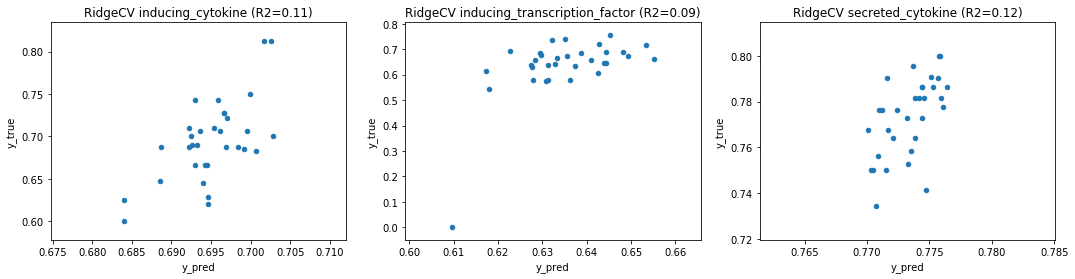

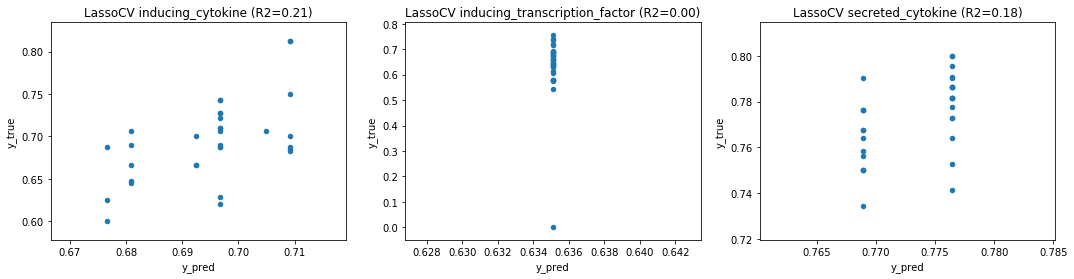

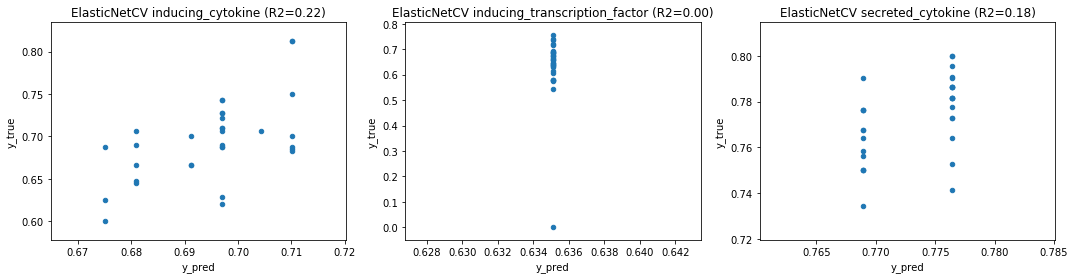

In [36]:
df_coef = pd.concat([
    get_coefs(RidgeCV(normalize=True, cv=5))[1],
    get_coefs(LassoCV(normalize=True, cv=5, random_state=1))[1],
    get_coefs(ElasticNetCV(normalize=True, cv=5, random_state=1))[1]
])

# Add weight for each model as R2 for model / R2 for all models
df_coef = df_coef.groupby('task', group_keys=False).apply(lambda g: g.assign(weight=(g['score'] / g['score'].sum())))
df_coef = df_coef.set_index(['task', 'score', 'est', 'weight'])

df_coef.head()

In [37]:
df_coef_lng = df_coef.rename_axis('parameter', axis='columns').stack().rename('value').reset_index()
df_coef_lng['weighted_value'] = df_coef_lng['value'] * df_coef_lng['weight']
df_coef_lng.head()

,task,score,est,weight,parameter,value,weighted_value
0,inducing_cytokine,0.114171,RidgeCV,0.213015,bidirectional:False,0.000000,0.000000
1,inducing_cytokine,0.114171,RidgeCV,0.213015,cell_type:LSTM,0.000000,0.000000
2,inducing_cytokine,0.114171,RidgeCV,0.213015,dropout:0.0,0.000668,0.000142
3,inducing_cytokine,0.114171,RidgeCV,0.213015,dropout:0.25,0.003927,0.000837
4,inducing_cytokine,0.114171,RidgeCV,0.213015,dropout:0.5,-0.000316,-0.000067


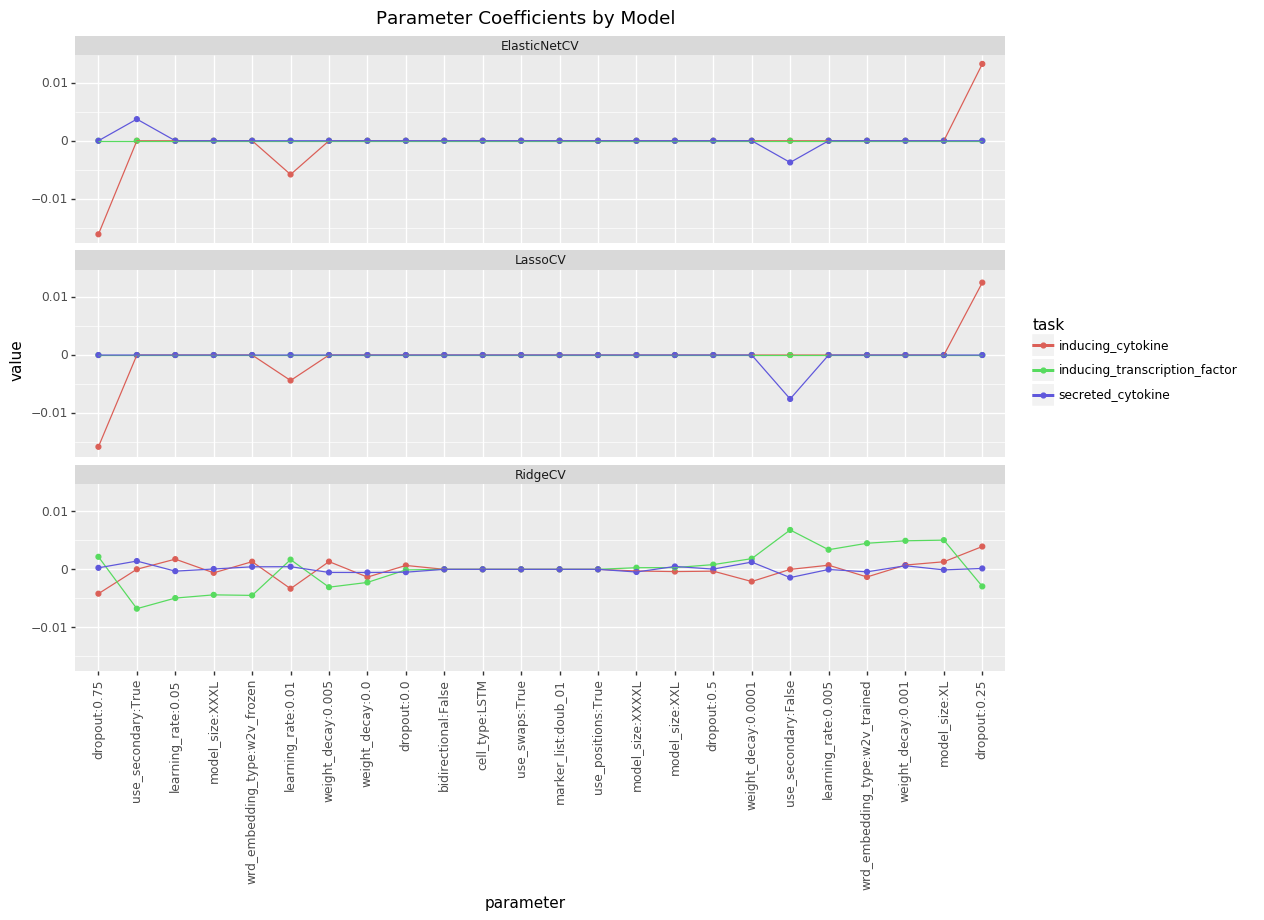

<ggplot: (-9223363255949882536)>

In [38]:
(
    pn.ggplot(
        df_coef_lng.assign(parameter=lambda df: pd.Categorical(
            df['parameter'], ordered=True, 
            categories=df.groupby('parameter')['weighted_value'].mean().sort_values().index
        )), 
        pn.aes(x='parameter', y='value', fill='task', color='task', group='task')
    ) + 
    pn.geom_point() +
    pn.geom_line() + 
    pn.ggtitle('Parameter Coefficients by Model') + 
    pn.facet_wrap('~ est', ncol=1) +
    pn.theme(figure_size=(12, 8), axis_text_x=pn.element_text(rotation=90, hjust=.5))
)

### Score Distributions

In [39]:
df_score = pd.concat([v[1].assign(task=k) for k, v in results.items()])
df_score.head()

,iteration,type,metric,value,task
0,0,,epoch,7.000000,inducing_cytokine
1,0,test,accuracy,0.560000,inducing_cytokine
2,0,test,ct,50.000000,inducing_cytokine
3,0,test,f1,0.633333,inducing_cytokine
4,0,test,loss,1.347603,inducing_cytokine


In [40]:
# Label balance
df_lbl = df_cand.assign(label=lambda df: np.where(df['label'] > .5, 1, 0))
pd.concat([
    df_lbl.assign(agg='count').groupby(['task', 'split', 'agg'])['label'].value_counts().unstack([-2, -1]),
    df_lbl.assign(agg='percent').groupby(['task', 'split', 'agg'])['label'].value_counts(normalize=True).unstack([-2, -1]).round(2)
], axis=1)

agg                                 count       percent      
label                                   0     1       0     1
task                          split                          
inducing_cytokine             test    246    25    0.91  0.09
                              train  5754  4246    0.58  0.42
                              val     189    14    0.93  0.07
inducing_transcription_factor test    224    57    0.80  0.20
                              train  6825  3175    0.68  0.32
                              val     174    35    0.83  0.17
secreted_cytokine             test    224    50    0.82  0.18
                              train  3235  6765    0.32  0.68
                              val     169    36    0.82  0.18

In [41]:
df_top_score = (
    df_score
    # Pivot to task and hyperparameter config number (all scores already filtered to best epoch)
    .pivot_table(index=['task', 'iteration'], columns=['metric', 'type'], values='value')
    # Remove models with early top score
    .pipe(lambda df: df[df[('epoch', '')] >= 5])
    # Filter to best model config based on validation score
    .pipe(lambda df: df.groupby('task').apply(lambda g: g.iloc[np.argmax(g[('f1', 'validation')].values)]))
)
df_top_score.head()

metric                         accuracy                          ct           \
type                               test  training validation   test training   
task                                                                           
inducing_cytokine              0.500000  0.725667   0.785714   50.0   3000.0   
inducing_transcription_factor  0.561404  0.633667   0.728571  114.0   3000.0   
secreted_cytokine              0.650000  0.939000   0.763889  100.0   3000.0   

metric                                   epoch        f1                       \
type                          validation            test  training validation   
task                                                                            
inducing_cytokine                   28.0  30.0  0.603175  0.751284   0.812500   
inducing_transcription_factor       70.0  35.0  0.583333  0.664222   0.739726   
secreted_cytokine                   72.0  26.0  0.732824  0.937692   0.800000   

metric                         ... precision@70 precision@80            \
type                           ...   validation         test  training   
task                           ...                                       
inducing_cytokine              ...       0.0000     0.000000  0.000000   
inducing_transcription_factor  ...       0.0000     0.000000  0.000000   
secreted_cytokine              ...       0.6875     0.584416  0.986436   

metric                                   precision@90                       \
type                          validation         test  training validation   
task                                                                         
inducing_cytokine               0.000000     0.000000  0.000000   0.000000   
inducing_transcription_factor   0.000000     0.000000  0.000000   0.000000   
secreted_cytokine               0.680851     0.577465  0.991057   0.659091   

metric                           recall                       
type                               test  training validation  
task                                                          
inducing_cytokine              0.760000  0.809245   0.928571  
inducing_transcription_factor  0.614035  0.727577   0.771429  
secreted_cytokine              0.960000  0.913736   0.944444  

[3 rows x 34 columns]

In [42]:
# Scores at best validation F1 iteration
def get_scores_table(metrics):
    df_bal = (
        df_lbl.assign(metric='balance').groupby(['task', 'metric', 'split'])['label'].value_counts(normalize=True)
        .unstack().round(2)[1].unstack([-2, -1])
    )
    return (
        df_top_score[metrics]
        .round(2)
        .pipe(lambda df: pd.concat([df, df_bal], axis=1, sort=True))
        .style.background_gradient(cmap='Greens', low=.1, high=.3)
    )

In [43]:
# Scores at best validation F1 iteration
get_scores_table(['ct', 'f1', 'accuracy', 'precision', 'recall'])

In [44]:
# Median scores
p = (
    df_score
    .pipe(lambda df: df[df['metric'].isin(['precision', 'recall', 'f1'])])
    .groupby(['task', 'metric', 'type'])['value'].describe()[['mean', '25%', '50%', '75%']].unstack()['50%'].unstack()[['test', 'validation']]
    .round(3)
    .style.background_gradient(cmap='Greens', low=.3, high=.9)
)

In [45]:
p

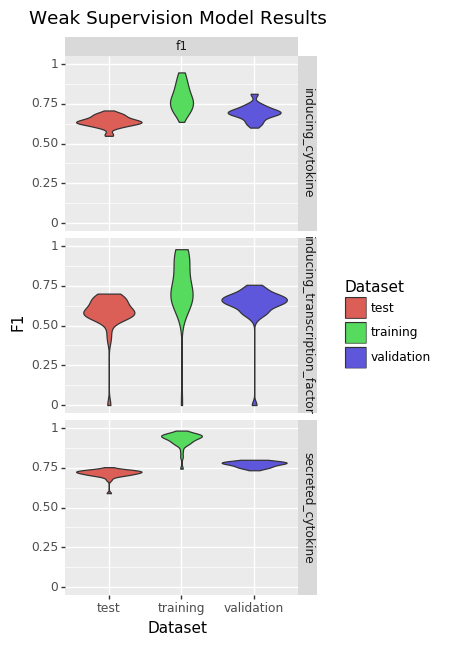

<ggplot: (8780901451668)>

In [46]:
(
    pn.ggplot(
        df_score.pipe(lambda df: df[df['metric'].isin(['f1'])]),
        pn.aes(x='type', y='value', fill='type')
    ) + 
    pn.geom_violin() + 
    pn.ylim(0, 1) +
    pn.labs(y='F1', title='Weak Supervision Model Results', x='Dataset', fill='Dataset') + 
    pn.facet_grid('task ~ metric', scales='free') + 
    pn.theme(figure_size=(3, 7))
)

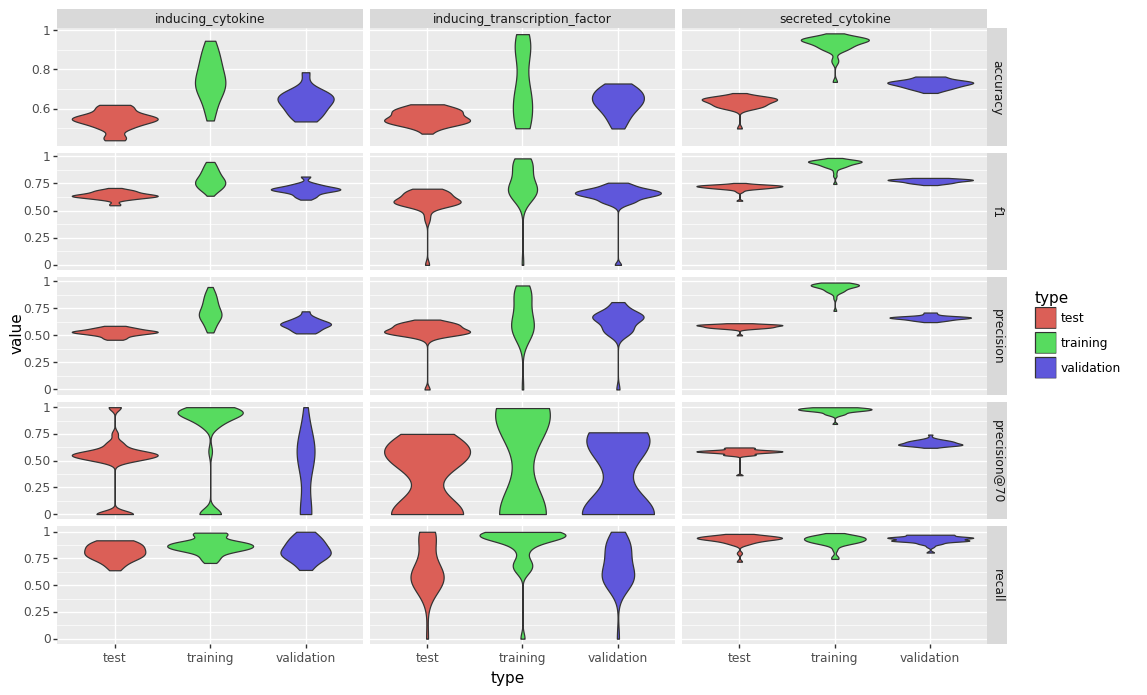

<ggplot: (8780901427576)>

In [47]:
(
    pn.ggplot(
        df_score.pipe(lambda df: df[df['metric'].isin(['f1', 'accuracy', 'precision', 'precision@70', 'recall'])]),
        pn.aes(x='type', y='value', fill='type')
    ) + 
    pn.geom_violin() + 
    pn.facet_grid('metric ~ task', scales='free') + 
    pn.theme(figure_size=(12, 8))
)

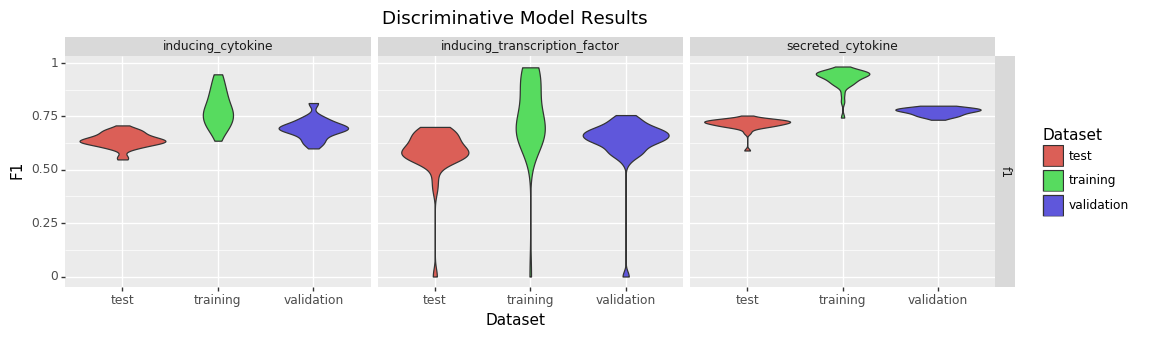

<ggplot: (-9223363255945068372)>

In [48]:
(
    pn.ggplot(
        df_score.pipe(lambda df: df[df['metric'].isin(['f1'])]),
        pn.aes(x='type', y='value', fill='type')
    ) + 
    pn.geom_violin() + 
    pn.labs(y='F1', title='Discriminative Model Results', x='Dataset', fill='Dataset') + 
    pn.facet_grid('metric ~ task', scales='free') + 
    pn.theme(figure_size=(12, 3))
)

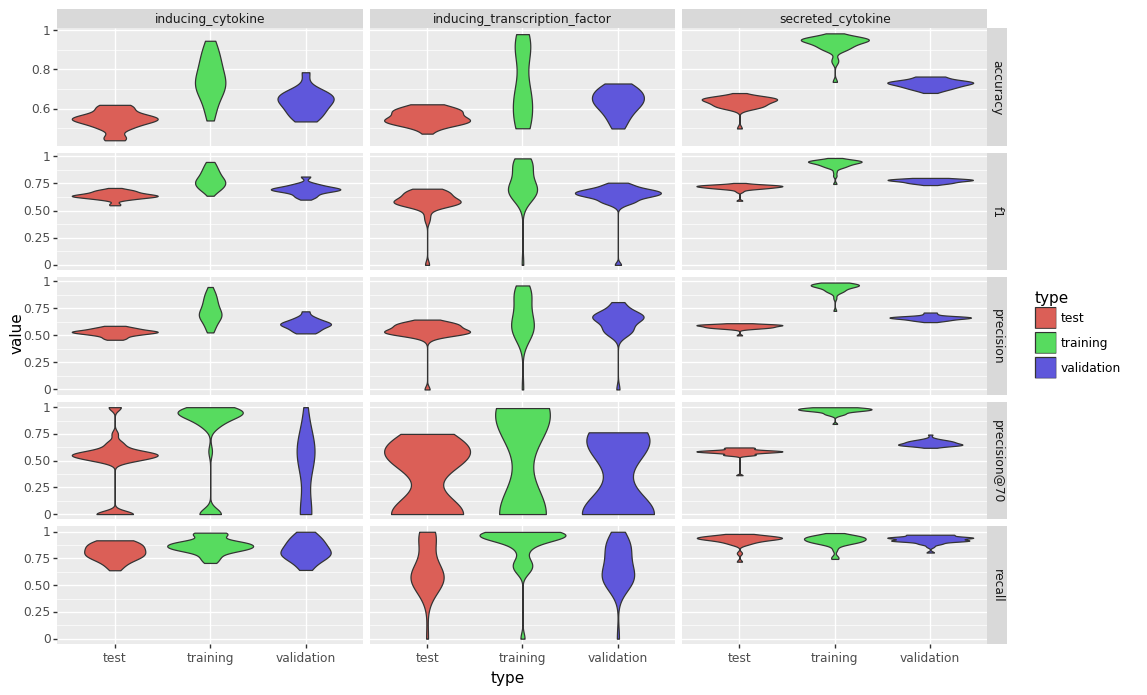

<ggplot: (-9223363255978622506)>

In [49]:
(
    pn.ggplot(
        df_score.pipe(lambda df: df[df['metric'].isin(['f1', 'accuracy', 'precision', 'precision@70', 'recall'])]),
        pn.aes(x='type', y='value', fill='type')
    ) + 
    pn.geom_violin() + 
    pn.facet_grid('metric ~ task', scales='free') + 
    pn.theme(figure_size=(12, 8))
)

In [50]:
# Dump all summaries
pd.set_option('display.max_rows', 100)
(
    df_score
    .pipe(lambda df: df[~df['metric'].isin(['lr', 'loss', 'ct', 'epoch'])])
    .groupby(['task', 'type', 'metric'])['value'].describe()
    .style.background_gradient(subset=pd.IndexSlice[:,'mean'])
)

## Export

Export scores:

In [54]:
df_exp = df_top_score.stack().stack().rename('value').reset_index().rename(columns={'type': 'split'}).assign(model='rnn-all')
assert df_exp.groupby(['task', 'metric', 'split']).size().max() == 1
df_exp.head()

,task,split,metric,value,model
0,inducing_cytokine,,epoch,30.000000,rnn-all
1,inducing_cytokine,test,accuracy,0.500000,rnn-all
2,inducing_cytokine,test,ct,50.000000,rnn-all
3,inducing_cytokine,test,f1,0.603175,rnn-all
4,inducing_cytokine,test,loss,0.704653,rnn-all


In [55]:
df_exp[df_exp['metric'] == 'epoch']['value'].value_counts()

26.0    1
35.0    1
30.0    1
Name: value, dtype: int64

In [57]:
path = osp.join(output_dir, 'scores.csv')
df_exp.to_csv(path, index=False)
path

'/lab/data/results/modeling-rnn-all/run3/scores.csv'